In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

In [ ]:


def train_flower_classifier(train_dir, test_dir, epochs=5):
    
    # Setup constants
    IMG_SIZE = (128, 128)
    BATCH_SIZE = 32
    
    # Create data generators
    data_generator = ImageDataGenerator(rescale=1.0/255)
    
    # Load and prepare data
    train_data = data_generator.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    
    test_data = data_generator.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    
    # Create model
    feature_extractor = hub.KerasLayer(
        "https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2",
        input_shape=(128, 128, 3),
        trainable=False
    )
    
    model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(train_data.num_classes, activation='softmax')
    ])
    
    # Compile and train
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=test_data
    )
    
    # Evaluate
    loss, accuracy = model.evaluate(test_data)
    print(f"\nTest accuracy: {accuracy:.2f}")
    
    return model, train_data.class_indices

# Example usage:

# Paths to training and testing data
train_dir = r"D:\Work\python\dl_clg\datasets\Flowers\train"
test_dir = r"D:\Work\python\dl_clg\datasets\Flowers\test"
model, class_indices = train_flower_classifier(train_dir, test_dir)

Found 3250 images belonging to 5 classes.
Found 530 images belonging to 5 classes.
Epoch 1/5
102/102 [==============================] - 13s 111ms/step - loss: 0.7547 - accuracy: 0.7194 - val_loss: 0.4875 - val_accuracy: 0.8358
Epoch 2/5
102/102 [==============================] - 11s 111ms/step - loss: 0.4059 - accuracy: 0.8569 - val_loss: 0.3944 - val_accuracy: 0.8585
Epoch 3/5
102/102 [==============================] - 11s 107ms/step - loss: 0.3262 - accuracy: 0.8917 - val_loss: 0.3816 - val_accuracy: 0.8604
Epoch 4/5
102/102 [==============================] - 11s 107ms/step - loss: 0.2784 - accuracy: 0.9086 - val_loss: 0.3433 - val_accuracy: 0.8660
Epoch 5/5
17/17 [==============================] - 2s 97ms/step - loss: 0.3326 - accuracy: 0.8830

Test accuracy: 0.88


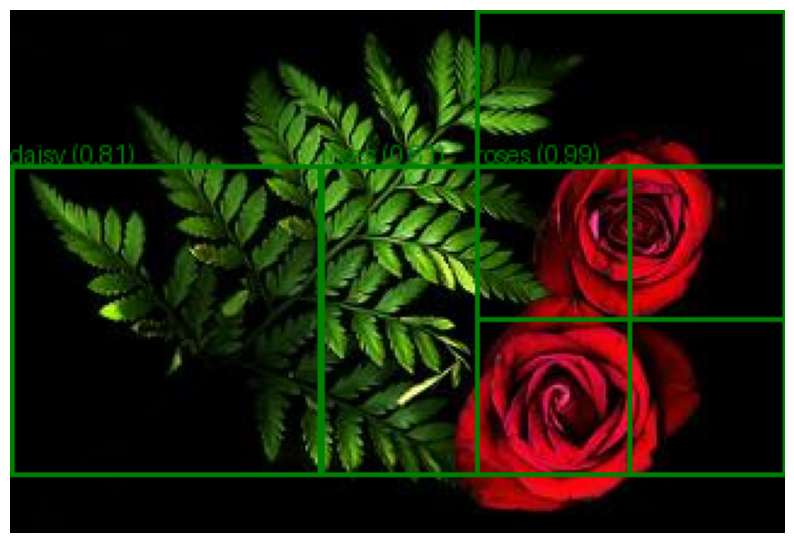

In [34]:

import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def detect_flowers(image_path, model, class_labels, confidence_threshold=0.8):
    # Load and prepare image
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    
    # Scanning parameters
    box_size = 128
    step_size = 64
    
    # Scan image
    for y in range(0, img.size[1] - box_size + 1, step_size):
        for x in range(0, img.size[0] - box_size + 1, step_size):
            # Get and process region
            region = img.crop((x, y, x + box_size, y + box_size))
            region = np.array(region.resize((128, 128))) / 255.0
            prediction = model.predict(np.expand_dims(region, 0), verbose=0)
            
            # Check confidence and draw if above threshold
            confidence = np.max(prediction)
            if confidence > confidence_threshold:
                flower_type = class_labels[np.argmax(prediction)]
                # Draw box and label
                draw.rectangle([(x, y), (x + box_size, y + box_size)], 
                             outline="green", width=2)
                draw.text((x, y - 10), 
                         f"{flower_type} ({confidence:.2f})", 
                         fill="green")
    
    # Display result
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example usage:
image_path = r"D:\Work\python\dl_clg\datasets\Flowers\test\roses\roses_424.jpg"
class_labels = [ 'daisy',"dandelion","roses","sunflowers","tulips"]
detect_flowers(image_path, model, class_labels)